# Black–Litterman Implementation to Overcome MVO Challenges

---

## Motivation: Why Black–Litterman?

- Traditional **Mean-Variance Optimization (MVO)** often produces **extreme or concentrated allocations** due to:  
  - Sensitivity to small changes in expected returns  
  - Poor handling of uncertainty in forecasts  
  - Overweighting assets with slightly higher expected returns  

- **Black–Litterman (BL)** combines **market equilibrium** and **investor views** to produce more stable, realistic portfolios.  

**Key Benefits over MVO:**
- Smooths extreme positions by blending prior returns (`pi`) with views.  
- Allows **flexible confidence** in views via `tau` and `Omega`.  
- Ensures allocations are more diversified and aligned with practical investment constraints.  
- Compatible with different risk-return objectives (Sharpe maximization, volatility targeting, etc.).

---

# Key Advantages of Black–Litterman

| Feature | Benefit |
|---------|--------|
| Combines market equilibrium + investor views | Produces realistic and diversified allocations |
| Confidence control via tau / Omega | Allows tuning influence of views |
| Robust to noisy expected returns | Less sensitivity than classical MVO |
| Flexible optimization objectives | Supports max Sharpe, min volatility, or target-risk portfolios |
| Gradual incorporation of views | Avoids extreme overweighting of single assets |

---

## Summary

Black–Litterman is a promising approach over MVO because it:  
- Mitigates concentration risk  
- Incorporates investor beliefs in a systematic way  
- Delivers more stable, practical portfolios across different optimization objectives


In [1]:
!pip install PyPortfolioOpt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 9.3 MB/s eta 0:00:00


In [2]:
# -----------------------------
# Imports
# -----------------------------

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
#from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import EfficientFrontier
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion

from pypfopt import (
    risk_models,
    expected_returns,
)
from scipy.optimize import minimize

In [3]:
# Dictionary of Indian market assets
assets = {
    "Reliance": "RELIANCE.NS",   # Reliance Industries
    "TCS": "TCS.NS",        # Tata Consultancy Services
    "Infosys":"INFY.NS",       # Infosys
    "HDFC Bank":"HDFCBANK.NS",   # HDFC Bank
    "ICICI Bank":"ICICIBANK.NS",  # ICICI Bank
    "Hindustan Unilver":"HINDUNILVR.NS", # Hindustan Unilever
    "Larsen&Turbo":"LT.NS",         # Larsen & Toubro
    "Axis gold ETF":"AXISGOLD.NS",   # Axis Gold ETF
    "S&P 500 ETF":"^GSPC",         # S&P 500 (international diversification)
    "Bharat 22 ETF":"ICICIB22.NS",   # BHARAT 22 ETF
    "Bharat Bond":"EBBETF0430.NS", # The Bharat Bond ETF
    "LT Govt. Bond": "LTGILTBEES.NS", # Long term govt. bonds
    #"Volatility index":"^INDIAVIX", # India volatility index(excluding as not investable directly)
    "Bitcoin": "BTC-USD", # Crypto: Bitcoin
    "Ethereum": "ETH-USD", # Crypto: Ethereum
}


for name, ticker in assets.items():
  print(f'{name:15} (has the ticker): {ticker:30}')


Reliance        (has the ticker): RELIANCE.NS                   
TCS             (has the ticker): TCS.NS                        
Infosys         (has the ticker): INFY.NS                       
HDFC Bank       (has the ticker): HDFCBANK.NS                   
ICICI Bank      (has the ticker): ICICIBANK.NS                  
Hindustan Unilver (has the ticker): HINDUNILVR.NS                 
Larsen&Turbo    (has the ticker): LT.NS                         
Axis gold ETF   (has the ticker): AXISGOLD.NS                   
S&P 500 ETF     (has the ticker): ^GSPC                         
Bharat 22 ETF   (has the ticker): ICICIB22.NS                   
Bharat Bond     (has the ticker): EBBETF0430.NS                 
LT Govt. Bond   (has the ticker): LTGILTBEES.NS                 
Bitcoin         (has the ticker): BTC-USD                       
Ethereum        (has the ticker): ETH-USD                       


# Black–Litterman Implementation Steps

---

## Step 1: Calculate Returns

- Compute daily percentage returns based on current expected prices.  
- Convert daily returns to expected **annualized returns**.  

**Hedging Notes:**  
- Gold and debt instruments act as proxies to hedge equity risk.  
- In practice, direct hedging could involve VIX-related instruments, futures, or index options.

**Analysis:**  
- Plot a **correlation heatmap** to visualize how assets move together.

---

## Step 2: Set Up Expected Returns & Covariance Matrix

- For Black-Litterman, define:  
  - **Prior returns (π)**: market equilibrium expected returns  
  - **Covariance matrix (Σ)** of asset returns

---

In [4]:
# -----------------------------
# Assets to Analyze
# -----------------------------
#assets = assets

start_date = '2018-01-01'
end_date = '2024-12-31'

# -----------------------------
# Download Data
# -----------------------------
series_dict = {}
for name, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
    if not df.empty and 'Adj Close' in df.columns:
        series_dict[name] = df['Adj Close']
    else:
        print(f"⚠️ Skipped {name} ({ticker}) - no data returned")

# -----------------------------
# Build Price DataFrame
# -----------------------------
if not series_dict:
    raise ValueError("No valid data downloaded. Please check tickers.")

price_df = pd.concat(series_dict, axis=1)

# Daily returns
returns_df = price_df.pct_change().dropna()

# Check the first few rows
returns_df.head()


/tmp/ipython-input-3349654303.py:29: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()


,Reliance,TCS,Infosys,HDFC Bank,ICICI Bank,Hindustan Unilver,Larsen&Turbo,Axis gold ETF,S&P 500 ETF,Bharat 22 ETF,Bharat Bond,LT Govt. Bond,Bitcoin,Ethereum
Ticker,RELIANCE.NS,TCS.NS,INFY.NS,HDFCBANK.NS,ICICIBANK.NS,HINDUNILVR.NS,LT.NS,AXISGOLD.NS,^GSPC,ICICIB22.NS,EBBETF0430.NS,LTGILTBEES.NS,BTC-USD,ETH-USD
Date,,,,,,,,,,,,,,
2019-12-31,-0.019525,-0.009848,-0.002388,-0.007839,-0.009284,-0.007356,-0.003148,0.007059,0.002946,0.002332,-0.000153,-0.000494,-0.013629,-0.022789
2020-01-01,-0.002939,0.002729,0.007796,0.005110,-0.003990,0.007046,0.009051,0.010384,0.000000,0.003780,0.000691,0.003457,0.000914,0.009190
2020-01-02,0.017025,-0.004590,-0.002918,0.006374,0.007173,0.000775,0.026986,-0.009629,0.008379,0.002607,0.000013,0.000492,-0.029819,-0.025931
2020-01-03,0.001205,0.019929,0.015380,-0.014261,-0.003237,-0.005469,-0.007619,0.026087,-0.007060,0.002600,0.000097,0.001476,0.051452,0.053069
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008955,0.006690


Expected retruns of the securities



/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


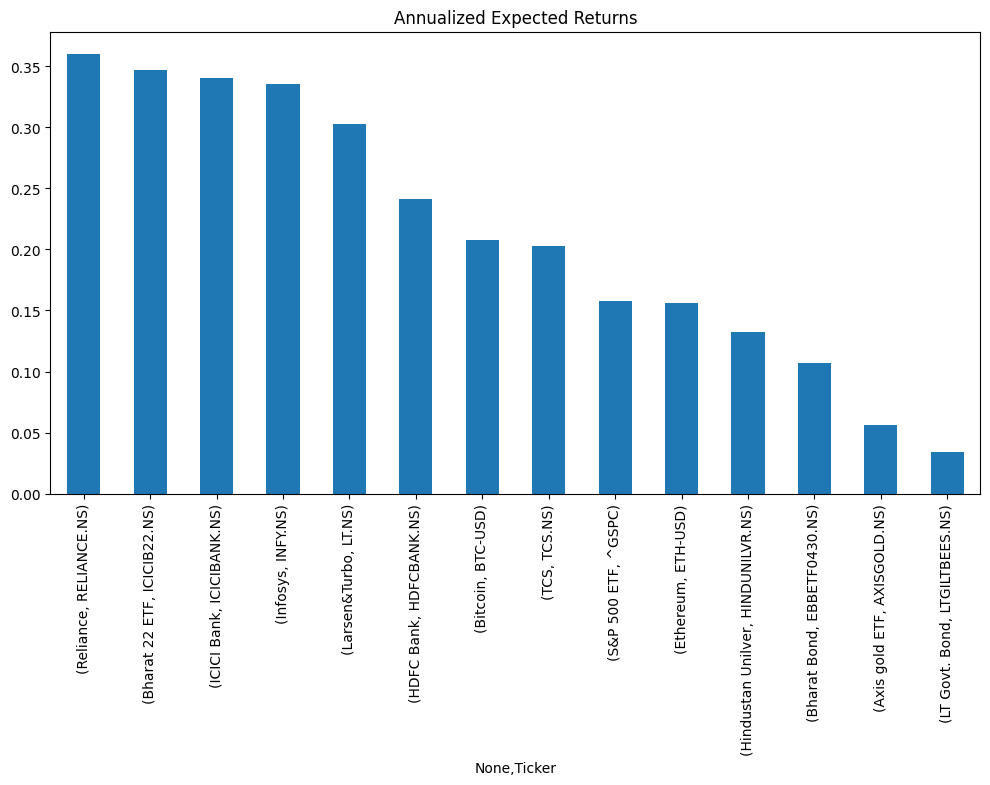

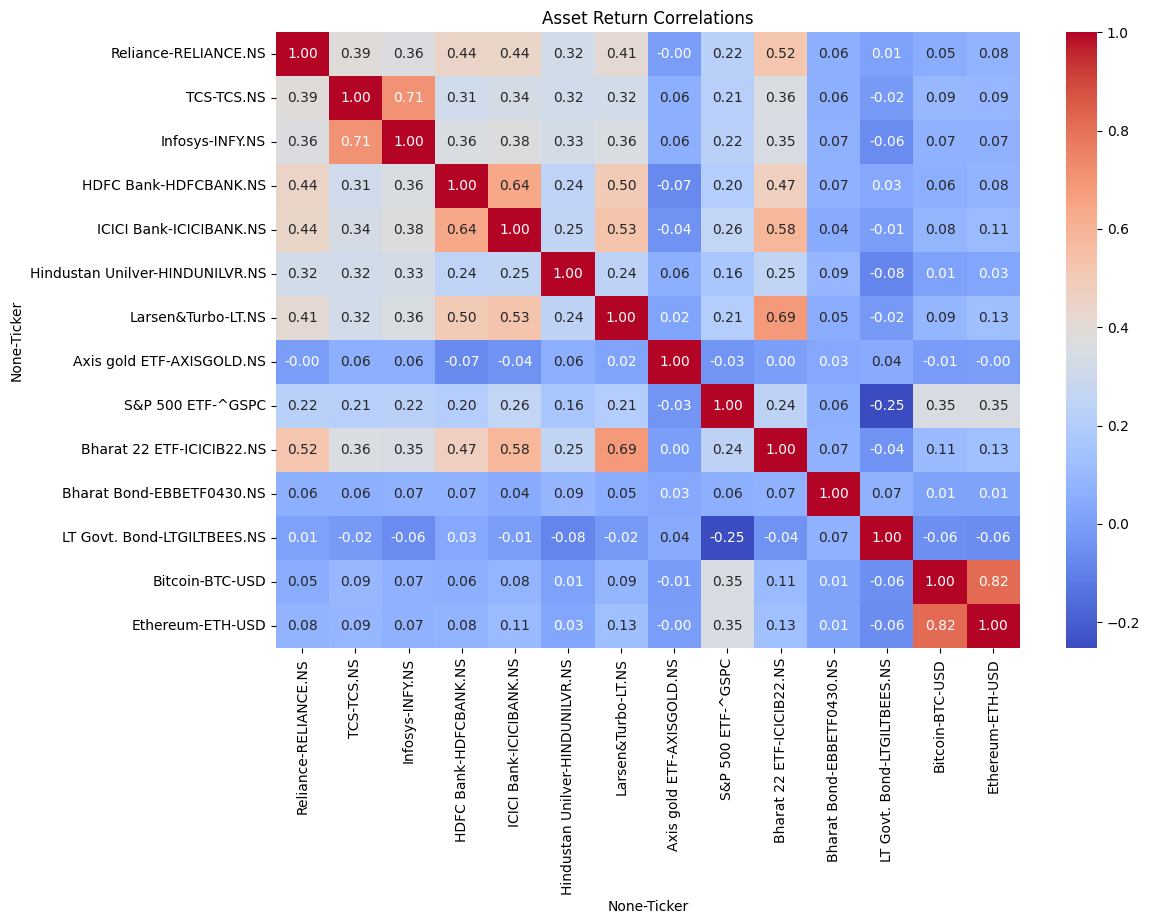

In [8]:
# Annualized mean historical returns
mu = mean_historical_return(price_df, frequency=252)

# Covariance matrix using shrinkage
S = CovarianceShrinkage(price_df).ledoit_wolf()

print("Expected retruns of the securities\n")
# Quick look at expected returns
#mu.sort_values(ascending=False)
#print(mu.sort_values(ascending=False),"\n")

mu.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), title="Annualized Expected Returns")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Asset Return Correlations")
plt.show()



## Step 3: Specify Views for Black-Litterman

### Example Views:
- Reliance will outperform HDFC Bank by 2%  
- Bitcoin will have 15% expected return  

---

## Understanding the Role of π (pi)

- `pi` represents **prior (market equilibrium) expected returns**, usually derived from:  
  - Market-cap-weighted benchmark  
  - Reverse optimization using covariance matrix and market weights  
- `pi` is **not** the confidence in your views; it is the baseline expectation.  
- If `pi=None`, PyPortfolioOpt assumes zero prior returns → your views dominate fully.

---

## Confidence in the Views

- Controlled by **tau (τ)** in Black-Litterman:  
  - Scalar, small number (e.g., 0.025–0.05)  
  - Lower tau → more confidence in prior (market)  
  - Higher tau → more confidence in your views  

**PyPortfolioOpt Limitation:**  
- Cannot set confidence per view directly in `absolute_views`.  

---

## How Confidence Works in Practice

**Mathematical Formula:**

$\text{BL returns} = \pi + \tau \Sigma P^T (P \tau \Sigma P^T + \Omega)^{-1} (Q - P\pi)$

Where:  
- $\Sigma$ = covariance matrix  
- $P$ = picks matrix (which asset each view relates to)  
- $Q$ = vector of views  
- $\Omega$ = diagonal matrix of view uncertainties (larger = less confident)  
- $\tau$ = scalar controlling confidence in the prior  

**In PyPortfolioOpt:**  
- `tau` = confidence in prior  
- Smaller tau → market prior trusted more  
- Larger tau → views dominate

---

## 4️⃣ Optional: Adjust Confidence per View

- Use **Q**, **P**, and **Omega** matrices for advanced views:

```python
# Q = vector of views
# P = pick matrix
# Omega = confidence (variance) of each view
bl = BlackLittermanModel(
    S,
    pi=pi,
    absolute_views={"RELIANCE.NS": 0.36, "BTC-USD": 0.20},
    tau=0.05,
    omega=np.diag([0.01, 0.05])  # lower = more confident
)


/usr/local/lib/python3.12/dist-packages/pypfopt/black_litterman.py:258: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")



Weights from BL(Max_Sharpe optimization): 

RELIANCE.NS     : 0.032 

TCS.NS          : 0.007 

INFY.NS         : 0.039 

HDFCBANK.NS     : 0.012 

ICICIBANK.NS    : 0.024 

HINDUNILVR.NS   : 0.007 

LT.NS           : 0.016 

AXISGOLD.NS     : 0.046 

^GSPC           : 0.028 

ICICIB22.NS     : 0.111 

EBBETF0430.NS   : 0.662 

LTGILTBEES.NS   : 0.014 

BTC-USD         : 0.001 

ETH-USD         : 0.000 

Expected annual return: 10.2%
Annual volatility: 3.8%
Sharpe Ratio: 2.69


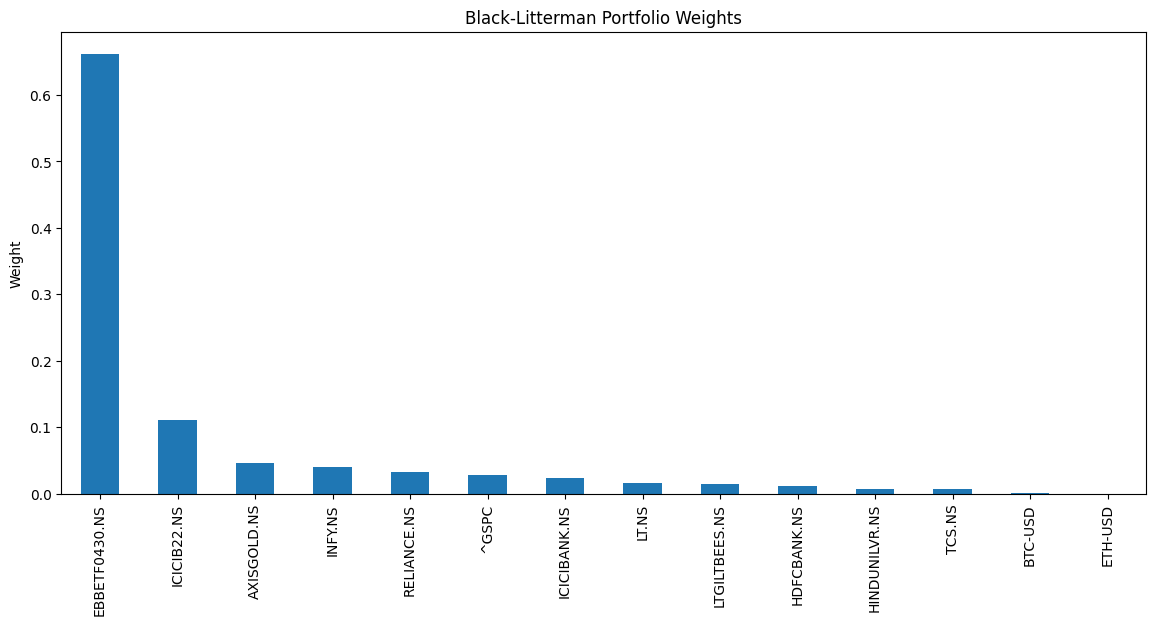

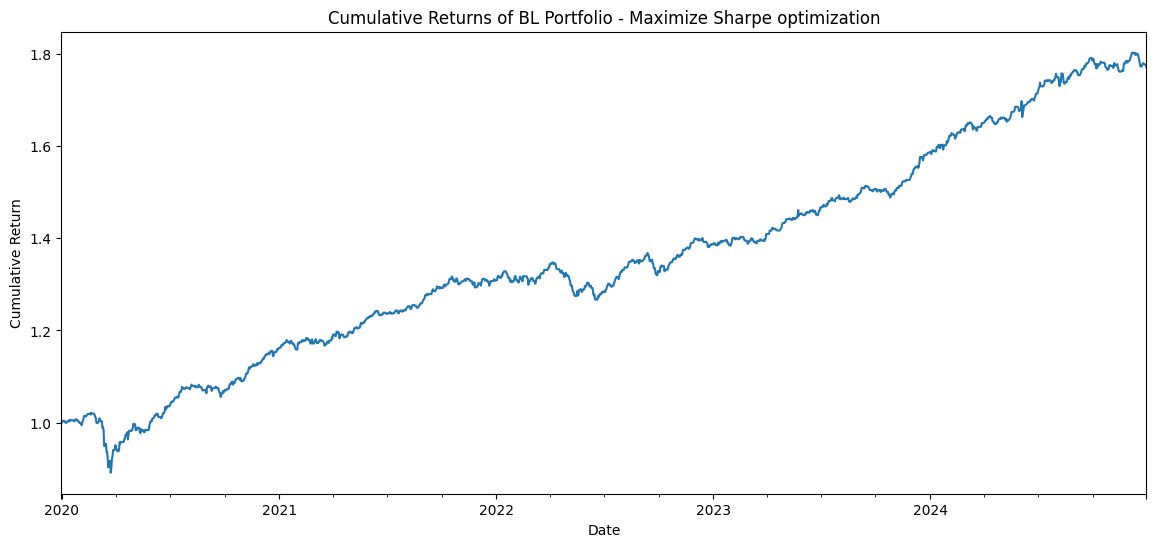


Weights from BL(minimum volatility optimization): 

RELIANCE.NS     : 0.000 

TCS.NS          : 0.003 

INFY.NS         : 0.000 

HDFCBANK.NS     : 0.000 

ICICIBANK.NS    : 0.000 

HINDUNILVR.NS   : 0.020 

LT.NS           : 0.000 

AXISGOLD.NS     : 0.081 

^GSPC           : 0.037 

ICICIB22.NS     : 0.017 

EBBETF0430.NS   : 0.736 

LTGILTBEES.NS   : 0.107 

BTC-USD         : 0.001 

ETH-USD         : 0.000 

Expected annual return: 5.9%
Annual volatility: 2.9%
Sharpe Ratio: 2.05


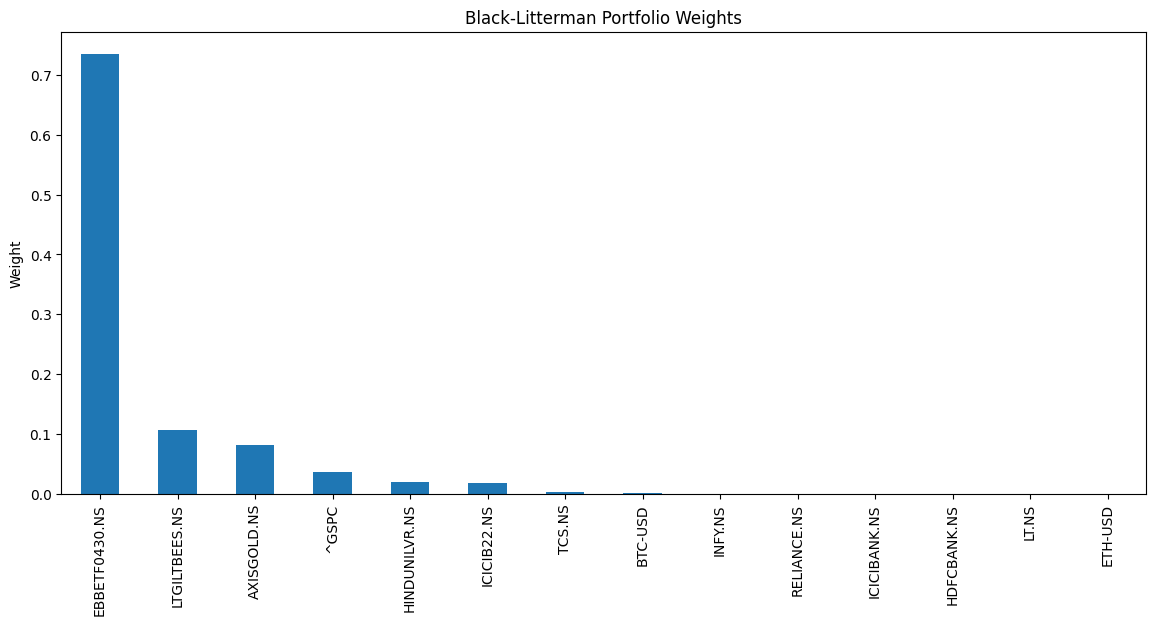

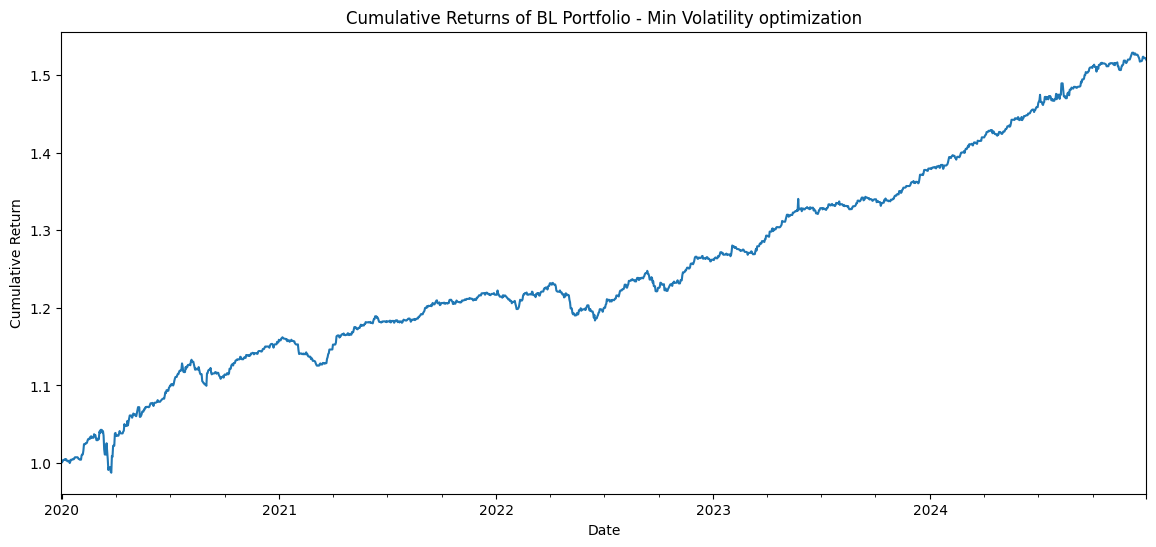


Weights from BL(Target volatility optimization): 

RELIANCE.NS     : 0.116 

TCS.NS          : 0.000 

INFY.NS         : 0.148 

HDFCBANK.NS     : 0.034 

ICICIBANK.NS    : 0.086 

HINDUNILVR.NS   : 0.000 

LT.NS           : 0.070 

AXISGOLD.NS     : 0.000 

^GSPC           : 0.013 

ICICIB22.NS     : 0.329 

EBBETF0430.NS   : 0.201 

LTGILTBEES.NS   : 0.000 

BTC-USD         : 0.003 

ETH-USD         : 0.001 

Expected annual return: 20.5%
Annual volatility: 9.0%
Sharpe Ratio: 2.28


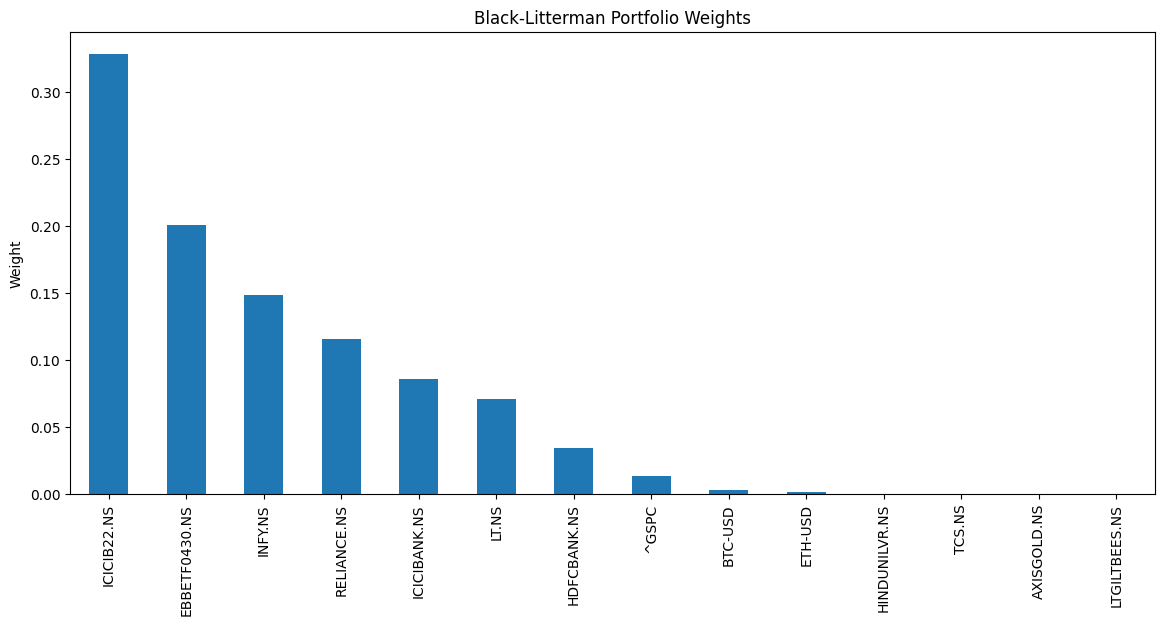

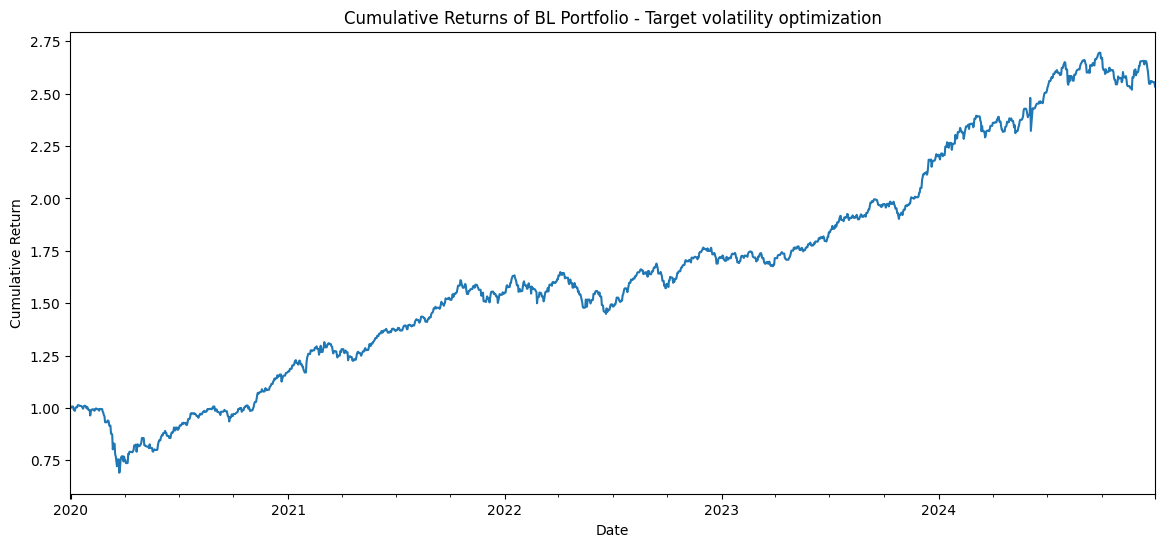

In [9]:
# The view is same as expected returns for initial run
absolute_views = {
    "RELIANCE.NS": 0.360376,
    "ICICIB22.NS": 0.346995,
    "ICICIBANK.NS": 0.340080,
    "INFY.NS": 0.335245,
    "LT.NS": 0.302653,
    "HDFCBANK.NS": 0.238392,
    "BTC-USD": 0.207831,
    "TCS.NS": 0.202394,
    "^GSPC": 0.157739,
    "ETH-USD": 0.155888,
    "HINDUNILVR.NS": 0.132594,
    "EBBETF0430.NS": 0.106728,
    "AXISGOLD.NS": 0.055885,
    "LTGILTBEES.NS": 0.033751,
    #"^INDIAVIX": -0.913616
}

# Covariance matrix using Ledoit-Wolf shrinkage
S = CovarianceShrinkage(price_df).ledoit_wolf()

# Flatten columns of S if it's a MultiIndex
if isinstance(S.columns, pd.MultiIndex):
    S.columns = S.columns.get_level_values(1)
    S.index = S.index.get_level_values(1)
"""
# Check tickers in S
print(S.columns.tolist())

# Ensure all tickers exist in S
for ticker in absolute_views.keys():
    if ticker not in S.columns:
        print(f"Ticker not in universe: {ticker}")
"""

# Using absolute views from historical returns
bl = BlackLittermanModel(S, pi=None, absolute_views=absolute_views)  # pi=None uses zero market prior
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

#print("Black-Litterman Adjusted Returns:\n", bl_returns)

ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print("\nWeights from BL(Max_Sharpe optimization): \n")
for i, j in zip(cleaned_weights.keys(),cleaned_weights.values()):
  print(f"{i:<15} : {j:.3f} \n")

ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Step 1: flatten columns if they are MultiIndex
if isinstance(returns_df.columns, pd.MultiIndex):
    returns_df.columns = returns_df.columns.get_level_values(1)

# Step 2: create weights series
weights_series = pd.Series(cleaned_weights)

# Step 3: reindex returns_df to match weights
returns_aligned = returns_df[weights_series.index]

# Step 4: compute portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of BL Portfolio - Maximize Sharpe optimization")
plt.ylabel("Cumulative Return")
plt.show()


# Min volatility optimization
#print("Black-Litterman Adjusted Returns:\n", bl_returns)

ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

print("\nWeights from BL(minimum volatility optimization): \n")
for i, j in zip(cleaned_weights.keys(),cleaned_weights.values()):
  print(f"{i:<15} : {j:.3f} \n")

ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Step 1: flatten columns if they are MultiIndex
if isinstance(returns_df.columns, pd.MultiIndex):
    returns_df.columns = returns_df.columns.get_level_values(1)

# Step 2: create weights series
weights_series = pd.Series(cleaned_weights)

# Step 3: reindex returns_df to match weights
returns_aligned = returns_df[weights_series.index]

# Step 4: compute portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of BL Portfolio - Min Volatility optimization")
plt.ylabel("Cumulative Return")
plt.show()


# Target volatility: effricient risk optimization
ef = EfficientFrontier(bl_returns, bl_cov)
target_volatility = 0.09
weights = ef.efficient_risk(target_volatility)
cleaned_weights = ef.clean_weights()

print("\nWeights from BL(Target volatility optimization): \n")
for i, j in zip(cleaned_weights.keys(),cleaned_weights.values()):
  print(f"{i:<15} : {j:.3f} \n")

ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Step 1: flatten columns if they are MultiIndex
if isinstance(returns_df.columns, pd.MultiIndex):
    returns_df.columns = returns_df.columns.get_level_values(1)

# Step 2: create weights series
weights_series = pd.Series(cleaned_weights)

# Step 3: reindex returns_df to match weights
returns_aligned = returns_df[weights_series.index]

# Step 4: compute portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of BL Portfolio - Target volatility optimization")
plt.ylabel("Cumulative Return")
plt.show()


# Expected Return vs Cumulative Return (Realized)

One of the most misunderstood differences in portfolio analysis:

---

### 🔹 What does Cumulative Return = 2.5 mean?

- If the cumulative return line is at **2.5**, it means:

$\text{Wealth at time } T = 2.5 \times \text{Initial Wealth}$

- Example:  
  - If you started with **1.00** in 2020, by 2025 you’d have **2.50**.  
  - This represents a **+150% total return** over the period.

   Expected return is an estimate from mean daily returns × 252.

  Cumulative return is the realized compounding of actual daily returns.

  So cumulative return = realized path, expected return = statistical estimate.


## Models with prior, Views(expected future returns), with sensitivity parameters

In [10]:
#Step 1: Define the Views

absolute_views = {
    "RELIANCE.NS": 0.360376,
    "ICICIB22.NS": 0.346995,
    "ICICIBANK.NS": 0.340080,
    "INFY.NS": 0.335245,
    "LT.NS": 0.302653,
    "HDFCBANK.NS": 0.238392,
    "BTC-USD": 0.207831,
    "TCS.NS": 0.202394,
    "^GSPC": 0.157739,
    "ETH-USD": 0.155888,
    "HINDUNILVR.NS": 0.132594,
    "EBBETF0430.NS": 0.106728,
    "AXISGOLD.NS": 0.055885,
    "LTGILTBEES.NS": 0.033751,
    #"^INDIAVIX": -0.913616
}

# The confidence that the past returns will repeat
# Define confidence (variance) per view
confidence_dict = {
    "RELIANCE.NS": 0.01,
    "ICICIB22.NS": 0.02,
    "ICICIBANK.NS": 0.015,
    "INFY.NS": 0.015,
    "LT.NS": 0.02,
    "HDFCBANK.NS": 0.02,
    "BTC-USD": 0.05,       # lower confidence due to high volatility
    "TCS.NS": 0.015,
    "^GSPC": 0.03,
    "ETH-USD": 0.05,
    "HINDUNILVR.NS": 0.02,
    "EBBETF0430.NS": 0.025,
    "AXISGOLD.NS": 0.03,
    "LTGILTBEES.NS": 0.03,
    #"^INDIAVIX": 0.1        # very uncertain
}

# Omega = diagonal matrix of view uncertainties
Omega = np.diag([confidence_dict[ticker] for ticker in absolute_views.keys()])

#print("Sample Omega Matrix:\n", Omega)

Max Sharpe Optimized Portfolio Weights:

RELIANCE.NS: 2.14%
TCS.NS: 0.00%
INFY.NS: 3.65%
HDFCBANK.NS: 0.00%
ICICIBANK.NS: 1.19%
HINDUNILVR.NS: 0.00%
LT.NS: 0.00%
AXISGOLD.NS: 4.62%
^GSPC: 2.18%
ICICIB22.NS: 12.23%
EBBETF0430.NS: 72.98%
LTGILTBEES.NS: 0.89%
BTC-USD: 0.12%
ETH-USD: 0.00%


Expected annual return: 15.1%
Annual volatility: 3.6%
Sharpe Ratio: 4.17


/tmp/ipython-input-3590024869.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()
/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


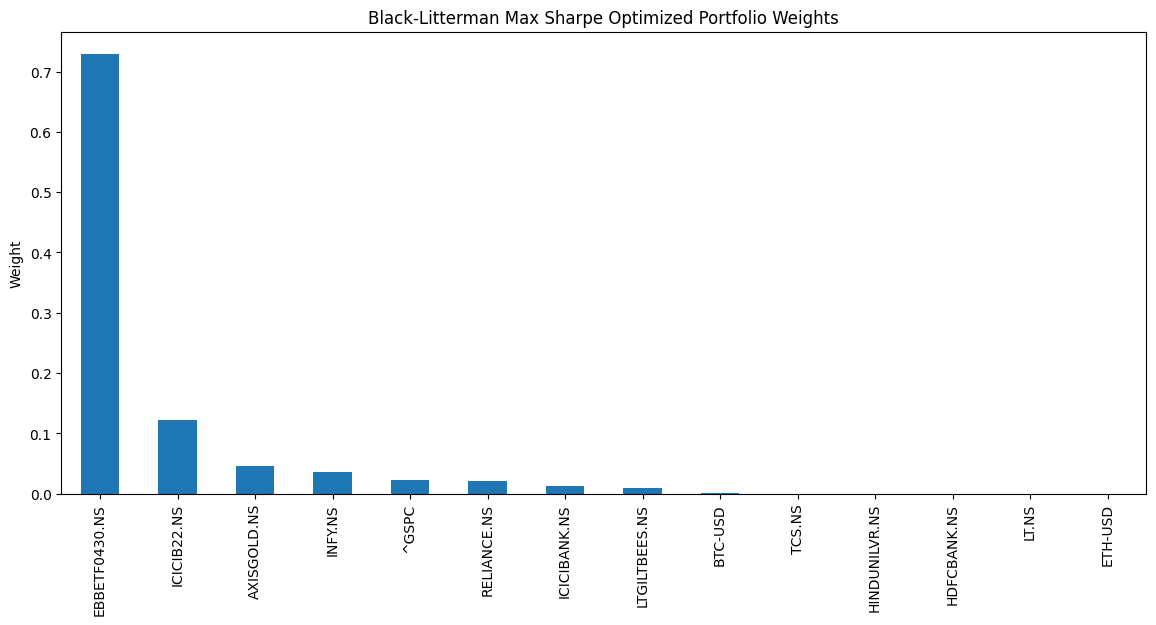

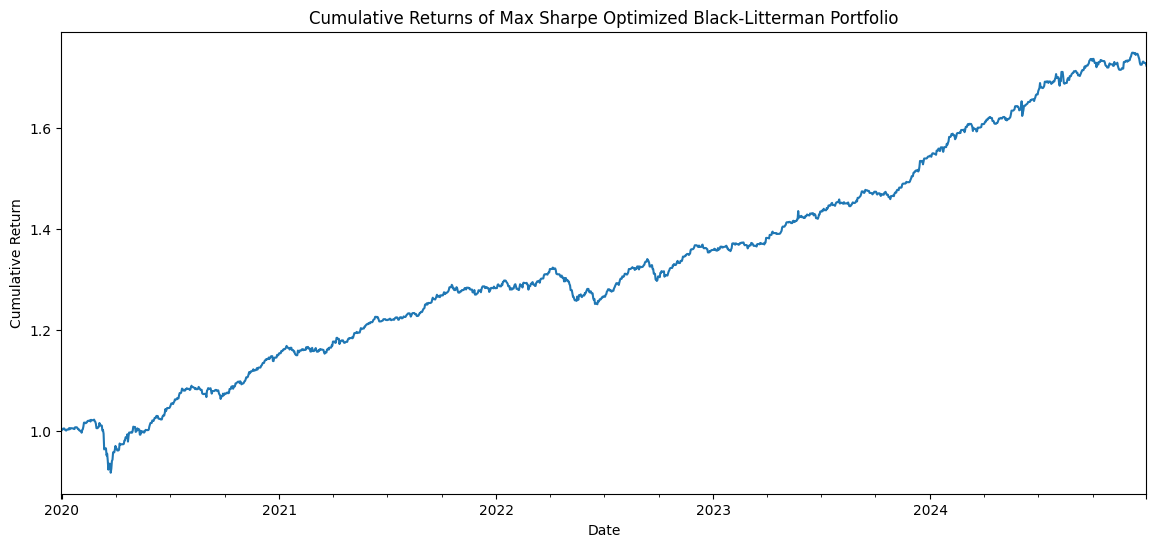

Min volatility Optimized Portfolio Weights:

RELIANCE.NS: 0.00%
TCS.NS: 0.36%
INFY.NS: 0.00%
HDFCBANK.NS: 0.00%
ICICIBANK.NS: 0.00%
HINDUNILVR.NS: 1.99%
LT.NS: 0.00%
AXISGOLD.NS: 7.94%
^GSPC: 3.61%
ICICIB22.NS: 1.80%
EBBETF0430.NS: 73.86%
LTGILTBEES.NS: 10.38%
BTC-USD: 0.07%
ETH-USD: 0.00%


Expected annual return: 10.2%
Annual volatility: 3.0%
Sharpe Ratio: 3.44


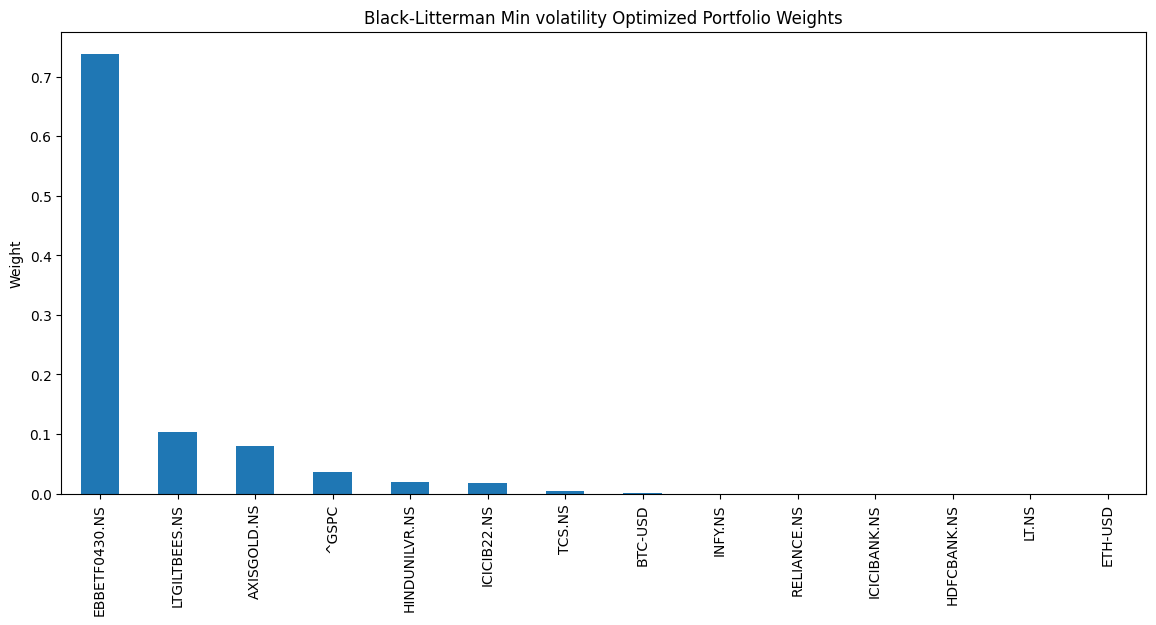

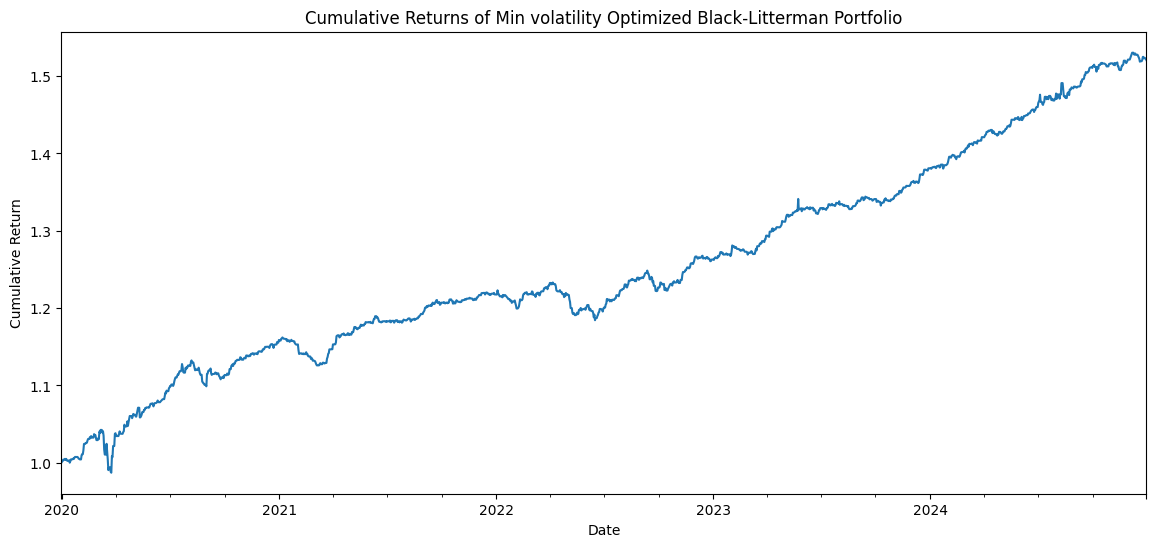

Target volatility Optimized Portfolio Weights:

RELIANCE.NS: 8.88%
TCS.NS: 0.00%
INFY.NS: 15.07%
HDFCBANK.NS: 0.00%
ICICIBANK.NS: 4.90%
HINDUNILVR.NS: 0.00%
LT.NS: 0.00%
AXISGOLD.NS: 0.00%
^GSPC: 0.00%
ICICIB22.NS: 47.48%
EBBETF0430.NS: 23.43%
LTGILTBEES.NS: 0.00%
BTC-USD: 0.24%
ETH-USD: 0.00%


Expected annual return: 28.9%
Annual volatility: 9.0%
Sharpe Ratio: 3.22


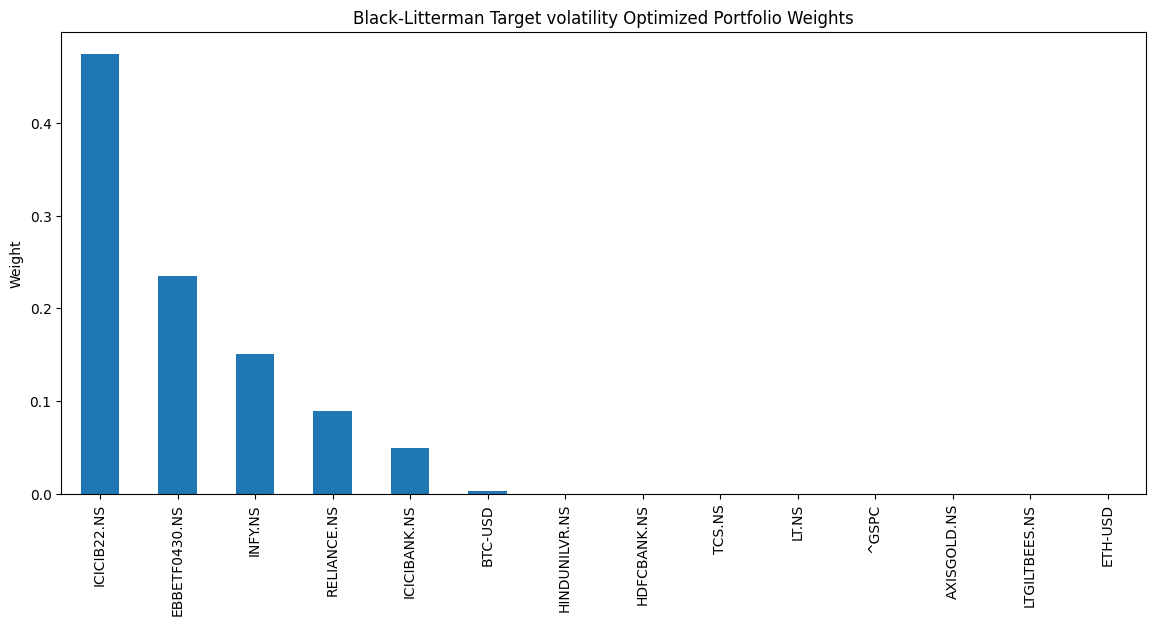

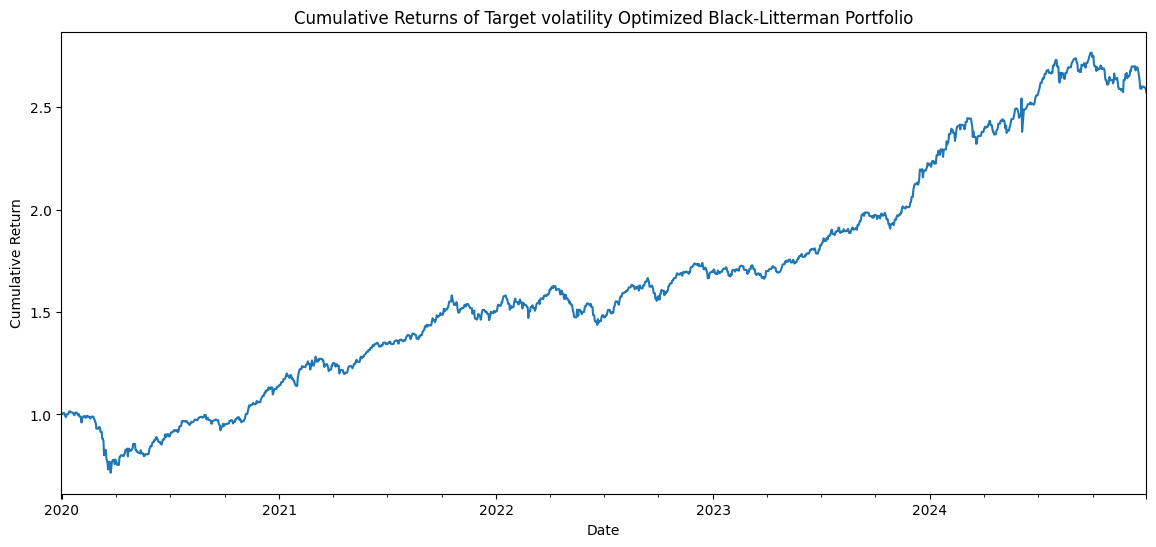

In [22]:
#Step 2 :

# Daily returns
returns_df = price_df.pct_change().dropna()

# Annualized expected returns = Pi
pi = mean_historical_return(price_df, frequency=252)

# Covariance matrix
S = CovarianceShrinkage(price_df).ledoit_wolf()

#step 3: The views can be partial and derived using other method or sources(can also be variation of historical expected returns)
absolute_views = pi.to_dict()

#step 4:
# Annualized volatility
volatility = returns_df.std() * np.sqrt(252)

# Scale volatilities to create Omega
# Omega = variance of each view = (volatility * scaling_factor)^2
scaling_factor = 0.5  # adjust as needed
Omega = np.diag((volatility[absolute_views.keys()] * scaling_factor)**2)

#Step 5:
tau = 0.2  # confidence in prior (smaller = more confident in Pi)

bl = BlackLittermanModel(
    S,
    pi=pi,
    absolute_views=absolute_views,
    tau=tau,
    omega=Omega
)

bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

# step 6:
ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print("Max Sharpe Optimized Portfolio Weights:\n")
for ticker, w in cleaned_weights.items():
    print(f"{ticker}: {w:.2%}")

# step 7:
# Align returns with weights
returns_aligned = returns_df[cleaned_weights.keys()]
weights_series = pd.Series(cleaned_weights)

# Portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

print("\n")
ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Max Sharpe Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of Max Sharpe Optimized Black-Litterman Portfolio")
plt.ylabel("Cumulative Return")
plt.show()

#min volatility model
# step 6:
ef = EfficientFrontier(bl_returns, bl_cov)

weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

print("Min volatility Optimized Portfolio Weights:\n")
for ticker, w in cleaned_weights.items():
    print(f"{ticker}: {w:.2%}")

# step 7:
# Align returns with weights
returns_aligned = returns_df[cleaned_weights.keys()]
weights_series = pd.Series(cleaned_weights)

# Portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

print("\n")
ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Min volatility Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of Min volatility Optimized Black-Litterman Portfolio")
plt.ylabel("Cumulative Return")
plt.show()


# Target volatility model
# step 6:
ef = EfficientFrontier(bl_returns, bl_cov)
target_volatility = 0.09
weights = ef.efficient_risk(target_volatility)
cleaned_weights = ef.clean_weights()

print("Target volatility Optimized Portfolio Weights:\n")
for ticker, w in cleaned_weights.items():
    print(f"{ticker}: {w:.2%}")

# step 7:
# Align returns with weights
returns_aligned = returns_df[cleaned_weights.keys()]
weights_series = pd.Series(cleaned_weights)

# Portfolio returns
portfolio_returns = returns_aligned.dot(weights_series)

print("\n")
ef.portfolio_performance(verbose=True)

plt.figure(figsize=(14,6))
pd.Series(cleaned_weights).sort_values(ascending=False).plot(kind='bar', title="Black-Litterman Target volatility Optimized Portfolio Weights")
plt.ylabel("Weight")
plt.show()

# Plot cumulative returns
(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="Cumulative Returns of Target volatility Optimized Black-Litterman Portfolio")
plt.ylabel("Cumulative Return")
plt.show()


# Improved Black–Litterman Pipeline (Enhanced & Robust)

Improved and hardened Black–Litterman workflow so it:  
1. Avoids a single asset dominating the portfolio  
2. Builds Omega in a more systematic way  
3. Searches for a sensible view-confidence scaling automatically  
4. Offers simple post-processing (hard caps + redistribution) and diagnostics (Herfindahl index, per-asset caps)  

The changes are conservative and compatible with PyPortfolioOpt functions already being used.

---

/tmp/ipython-input-9094105.py:36: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()
/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


Selected scaling: 0.001
Max weight (raw): 0.72195
Herfindahl index (raw): 0.5414065711999999

Final (capped + redistributed) weights:
ICICIB22.NS: 33.20%
EBBETF0430.NS: 25.00%
AXISGOLD.NS: 12.64%
INFY.NS: 9.37%
RELIANCE.NS: 8.65%
^GSPC: 5.69%
ICICIBANK.NS: 2.63%
LTGILTBEES.NS: 2.24%
BTC-USD: 0.58%
TCS.NS: 0.00%
HINDUNILVR.NS: 0.00%
HDFCBANK.NS: 0.00%
LT.NS: 0.00%
ETH-USD: 0.00%


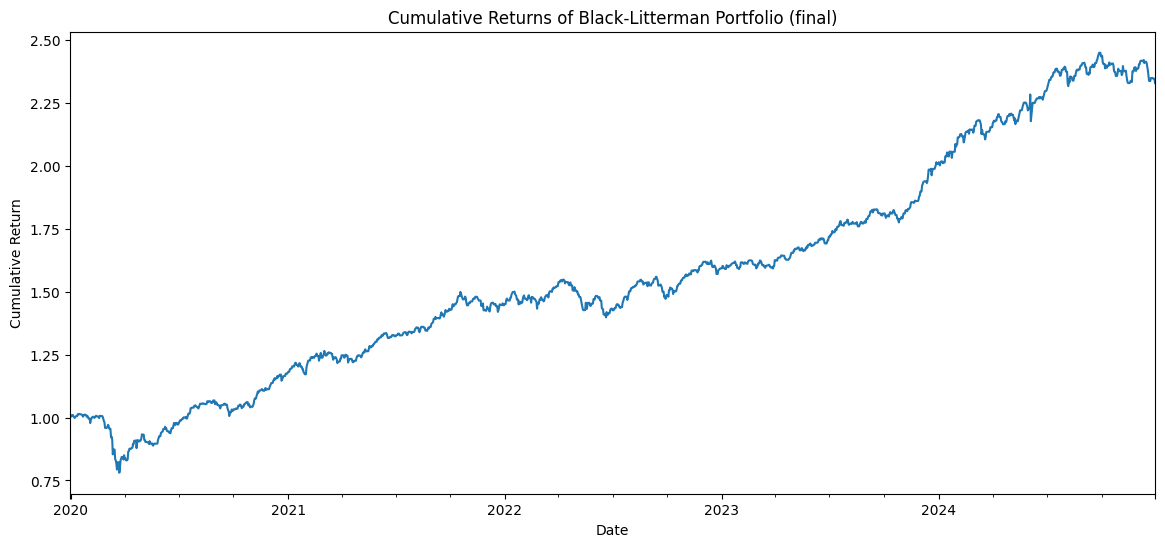


Portfolio diagnostics:
Annualized return (est): 12.09%
Annualized vol (est): 9.27%
Sharpe (est): 1.30
Herfindahl index: 0.2094


,weight
ICICIB22.NS,0.331991
EBBETF0430.NS,0.250000
AXISGOLD.NS,0.126425
INFY.NS,0.093706
RELIANCE.NS,0.086531
^GSPC,0.056887
ICICIBANK.NS,0.026272
LTGILTBEES.NS,0.022415
BTC-USD,0.005772
TCS.NS,0.000000


In [16]:
# ---------- Helper functions ----------
def herfindahl_index(weights_dict):
    """Herfindahl–Hirschman-style concentration measure (0 -> perfectly diversified, 1 -> single asset)."""
    w = np.array(list(weights_dict.values()), dtype=float)
    return np.sum(w ** 2)

def cap_and_redistribute(weights_dict, max_weight=0.25, min_weight=0.0):
    """
    Enforce simple hard cap: any asset weight > max_weight is reduced to max_weight,
    excess weight redistributed proportionally to the remaining non-capped assets (respecting min_weight).
    Returns new dict of weights that sum to 1 (or close due to numerical).
    """
    w = pd.Series(weights_dict).astype(float)
    # Clip top
    capped = w.clip(upper=max_weight)
    excess = w.sum() - capped.sum()
    # Identify candidates for redistribution
    candidates = capped[capped < max_weight]
    if len(candidates) == 0 or excess <= 0:
        w_new = capped / capped.sum()
        return w_new.to_dict()
    # Redistribute proportionally to candidates' current shares
    proportions = candidates / candidates.sum()
    capped.loc[proportions.index] += proportions * excess
    # enforce min_weight lower bound
    capped = capped.clip(lower=min_weight)
    # final normalization
    capped = capped / capped.sum()
    return capped.to_dict()

# ---------- Inputs (use your existing price_df) ----------
# price_df: DataFrame of historical prices (index = dates, columns = tickers)
# the user already has price_df; replace below if needed.

# ---------- Step 1: returns, risk, prior ----------
returns_df = price_df.pct_change().dropna()

# if MultiIndex columns (sometimes from data sources), flatten
if isinstance(returns_df.columns, pd.MultiIndex):
    returns_df.columns = returns_df.columns.get_level_values(1)

# if MultiIndex columns (sometimes from data sources), flatten
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = price_df.columns.get_level_values(1)

# Prior expected returns (Pi) - annualized
pi = mean_historical_return(price_df, frequency=252)

# Covariance (shrunk)
S = CovarianceShrinkage(price_df).ledoit_wolf()
if isinstance(S.columns, pd.MultiIndex):
    S.columns = S.columns.get_level_values(1)
if isinstance(S.index, pd.MultiIndex):
    S.index = S.index.get_level_values(1)

# ---------- Step 2: define views ----------
# Your absolute views (example from your snippet)
absolute_views = {
    "RELIANCE.NS": 0.40,
    "BTC-USD": 0.25,
    "ETH-USD": 0.20,
}

# Validate views tickers present in prices
missing = [t for t in absolute_views.keys() if t not in price_df.columns]
if missing:
    raise ValueError(f"The following view tickers are not in price_df.columns: {missing}")

# ---------- Step 3: view uncertainty (Omega) and tau search ----------
# We'll attempt multiple scaling_factors on volatility to find a scaling that produces a diversified portfolio.
volatility = returns_df.std() * np.sqrt(252)

# User-adjustable parameters
tau = 0.05                   # prior uncertainty (smaller -> more trust in pi)
min_scaling = 0.001
max_scaling = 0.5
n_scalings = 30              # try 30 values between min_scaling and max_scaling
target_max_weight = 0.25     # acceptable maximum weight per asset
target_herfindahl = 0.20     # optional target for concentration (lower => more diversified)
allow_short = False          # we will enforce non-negative weights later by post-process
risk_free_rate = 0.0         # if you want to set a different rf when maximizing Sharpe

scalings = np.linspace(min_scaling, max_scaling, n_scalings)

best_result = None
results = []

for s in scalings:
    # Build Omega from scaled volatilities (simple, transparent approach)
    # smaller s => smaller Omega => more confident in views (tighter)
    omega_values = [(volatility[ticker] * s)**2 for ticker in absolute_views.keys()]
    Omega = np.diag(omega_values)

    try:
        bl = BlackLittermanModel(
            S,
            pi=pi,
            absolute_views=absolute_views,
            tau=tau,
            omega=Omega
        )
        bl_returns = bl.bl_returns()
        bl_cov = bl.bl_cov()

        ef = EfficientFrontier(bl_returns, bl_cov)
        # If you want L2 regularization: ef.add_objective(objective_functions.L2_reg, gamma=0.1)
        raw_weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
        cleaned = ef.clean_weights()
    except Exception as e:
        # if any scaling causes numerical issues, skip
        results.append({'scaling': s, 'error': str(e)})
        continue

    # compute concentration and max weight
    max_w = max(cleaned.values())
    h_index = herfindahl_index(cleaned)

    results.append({
        'scaling': s,
        'max_weight': max_w,
        'herfindahl': h_index,
        'weights': cleaned
    })

    # choose best candidate that respects target_max_weight (first-fit) or the least concentrated
    if max_w <= target_max_weight and (best_result is None or h_index < best_result['herfindahl']):
        best_result = results[-1]

# if none satisfied the strict cap, pick the least concentrated one
if best_result is None:
    valid = [r for r in results if 'weights' in r]
    if not valid:
        raise RuntimeError("No valid Black-Litterman solution found for any scaling. Check inputs.")
    best_result = min(valid, key=lambda r: r['herfindahl'])

print("Selected scaling:", best_result['scaling'])
print("Max weight (raw):", best_result['max_weight'])
print("Herfindahl index (raw):", best_result['herfindahl'])

# ---------- Step 4: enforce caps + redistribute ----------
raw_weights = best_result['weights']
capped_weights = cap_and_redistribute(raw_weights, max_weight=target_max_weight, min_weight=0.0)
# Create a cleaned series
weights_series = pd.Series(capped_weights).sort_values(ascending=False)
print("\nFinal (capped + redistributed) weights(custom function approach):")
for t, w in weights_series.items():
    print(f"{t}: {w:.2%}")

# ---------- Step 5: portfolio returns and diagnostics ----------
# Align returns
returns_aligned = returns_df[weights_series.index]

# Compute portfolio returns (daily)
portfolio_returns = returns_aligned.dot(weights_series)

# Cumulative returns plot
(1 + portfolio_returns).cumprod().plot(figsize=(14, 6), title="Cumulative Returns of Black-Litterman Portfolio (final)")
plt.ylabel("Cumulative Return")
plt.show()

# Compute some diagnostics
ann_return = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
hh = herfindahl_index(weights_series.to_dict())

print("\nPortfolio diagnostics:")
print(f"Annualized return (est): {ann_return:.2%}")
print(f"Annualized vol (est): {ann_vol:.2%}")
print(f"Sharpe (est): {sharpe:.2f}")
print(f"Herfindahl index: {hh:.4f}")

# ---------- Optional: Save weights to CSV ----------
out_df = pd.DataFrame.from_dict(capped_weights, orient='index', columns=['weight'])
#out_df.to_csv("bl_optimal_weights_capped.csv")
#print("\nSaved capped weights to bl_optimal_weights_capped.csv")

out_df['weight'].sort_values(ascending=False)

## Optimization using market-cap prior and weight constraints

## Key Improvements and Rationale

### Automatic Scaling Search for Omega
- Instead of a single arbitrary `scaling_factor`, the script tries several.  
- Goal: find a scaling that produces a portfolio below `target_max_weight` or with a lower concentration metric (Herfindahl index).  
- Pragmatic way to tune view confidence so one or two assets don't dominate.

### Transparent Omega Construction
- Omega is computed from annualized volatilities × scaling factor, squared.  
- Simple, defensible, and interpretable: more volatile assets → larger Omega → less confident view for the same scaling.

---




/tmp/ipython-input-291893282.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()
/tmp/ipython-input-291893282.py:78: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()
/usr/local/lib/python3.12/dist-packages/pypfopt/black_litterman.py:258: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


Computed risk aversion (delta): 2.6143350887613477

Posterior (BL) expected returns:
Ticker
RELIANCE.NS      0.370326
BTC-USD          0.235189
ETH-USD          0.208817
ICICIBANK.NS     0.135865
HDFCBANK.NS      0.122644
LT.NS            0.119246
ICICIB22.NS      0.100516
INFY.NS          0.096492
TCS.NS           0.090738
HINDUNILVR.NS    0.077913
^GSPC            0.052325
LTGILTBEES.NS    0.016804
EBBETF0430.NS    0.004215
AXISGOLD.NS     -0.006500
dtype: float64

Max Sharpe Optimized Portfolio Weights (BL with market-cap prior):
RELIANCE.NS: 15.00%
TCS.NS: 3.01%
INFY.NS: 1.23%
HDFCBANK.NS: 5.51%
ICICIBANK.NS: 1.87%
HINDUNILVR.NS: 7.42%
LT.NS: 0.29%
AXISGOLD.NS: 12.49%
^GSPC: 6.36%
ICICIB22.NS: 14.23%
EBBETF0430.NS: 15.00%
LTGILTBEES.NS: 15.00%
BTC-USD: 2.58%
ETH-USD: 0.00%


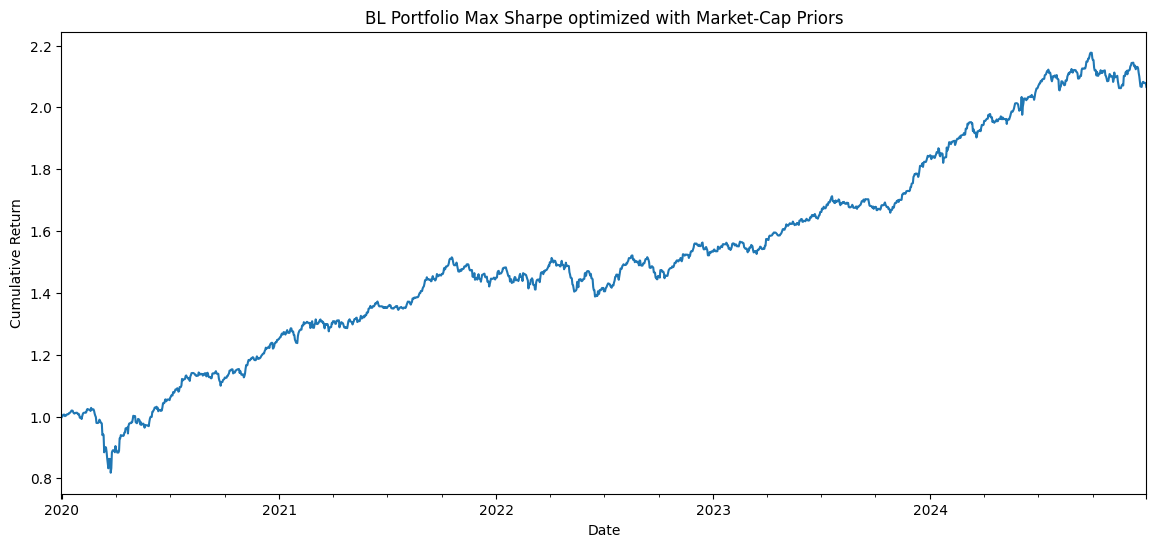


Portfolio diagnostics:
Annualized return (est): 10.38%
Annualized vol (est): 8.57%
Sharpe (est): 0.86
Herfindahl index: 0.1180

Min volatility Optimized Portfolio Weights (BL with market-cap prior):
RELIANCE.NS: 0.68%
TCS.NS: 5.93%
INFY.NS: 0.70%
HDFCBANK.NS: 5.44%
ICICIBANK.NS: 0.00%
HINDUNILVR.NS: 11.88%
LT.NS: 0.15%
AXISGOLD.NS: 15.00%
^GSPC: 15.00%
ICICIB22.NS: 15.00%
EBBETF0430.NS: 15.00%
LTGILTBEES.NS: 15.00%
BTC-USD: 0.21%
ETH-USD: 0.00%


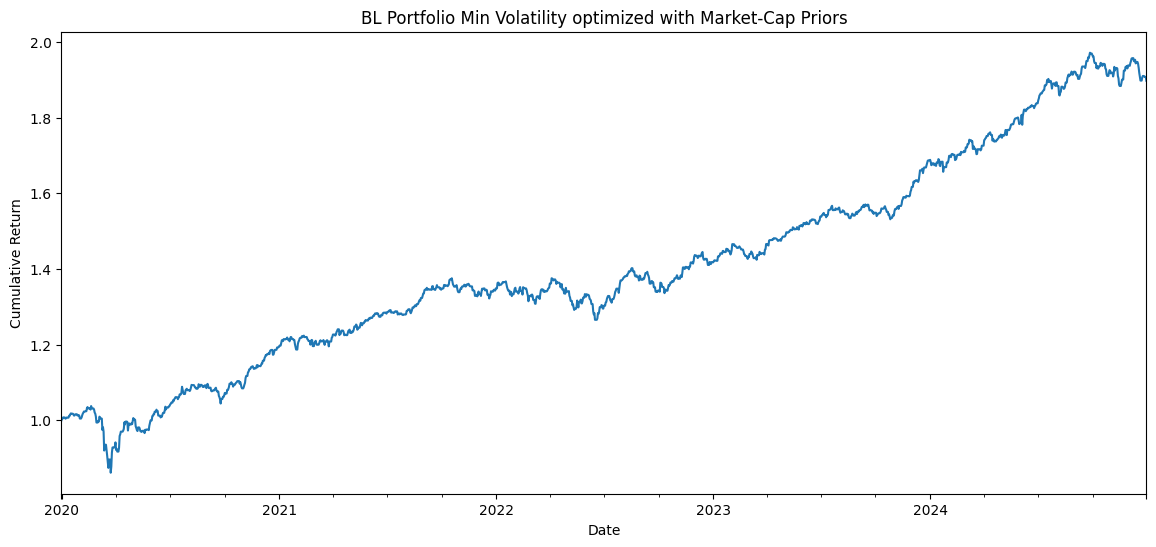


Portfolio diagnostics:
Annualized return (est): 9.09%
Annualized vol (est): 7.10%
Sharpe (est): 0.86
Herfindahl index: 0.1332

 Target volatility Optimized Portfolio Weights (BL with market-cap prior):
RELIANCE.NS: 30.00%
TCS.NS: 3.60%
INFY.NS: 3.62%
HDFCBANK.NS: 14.16%
ICICIBANK.NS: 9.45%
HINDUNILVR.NS: 7.41%
LT.NS: 3.48%
AXISGOLD.NS: 0.00%
^GSPC: 0.00%
ICICIB22.NS: 20.71%
EBBETF0430.NS: 0.00%
LTGILTBEES.NS: 0.00%
BTC-USD: 7.57%
ETH-USD: 0.00%


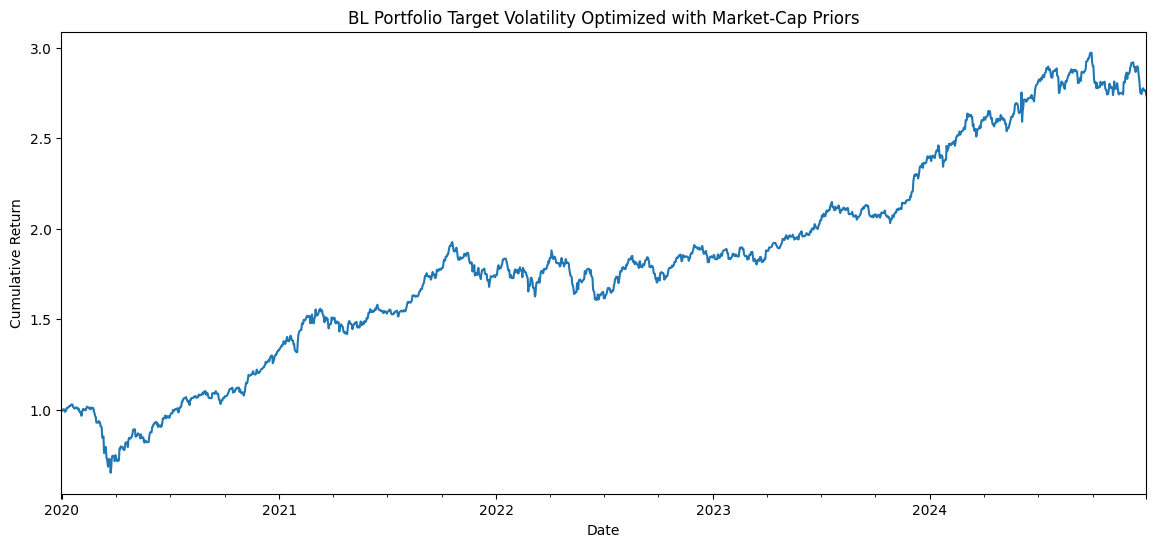


Portfolio diagnostics:
Annualized return (est): 15.20%
Annualized vol (est): 16.13%
Sharpe (est): 0.76
Herfindahl index: 0.1769


In [20]:
# ---------- Inputs ----------
# price_df: DataFrame of historical prices (index = dates, columns = tickers)
# market_caps: Series mapping ticker -> market cap (same tickers as price_df)

# Example (replace with your actual market caps):
market_caps = pd.Series({
    "RELIANCE.NS": 220e9,
    "TCS.NS": 150e9,
    "INFY.NS": 100e9,
    "HDFCBANK.NS": 80e9,
    "ICICIBANK.NS": 75e9,
    "HINDUNILVR.NS": 65e9,
    "LT.NS": 55e9,
    "AXISGOLD.NS": 10e9,
    "^GSPC": 30000e9,
    "ICICIB22.NS": 8e9,
    "EBBETF0430.NS": 7e9,
    "LTGILTBEES.NS": 5e9,
    "BTC-USD": 500e9,
    "ETH-USD": 200e9,
})

# ---------- Step 1: covariance ----------
S = CovarianceShrinkage(price_df).ledoit_wolf()
# Ensure covariance matrix has simple ticker index/columns
if isinstance(S.index, pd.MultiIndex):
    S.index = S.index.get_level_values(-1)
if isinstance(S.columns, pd.MultiIndex):
    S.columns = S.columns.get_level_values(-1)

# Reindex market_caps to match covariance matrix
market_caps = market_caps.reindex(S.index)

# Check for missing tickers
missing_caps = market_caps[market_caps.isna()]
if not missing_caps.empty:
    raise ValueError(f"Missing market cap values for: {list(missing_caps.index)}")


# ---------- Step 2: market-implied priors ----------
"""
market_weights = market_caps / market_caps.sum()
delta = market_implied_risk_aversion(price_df, market_weights=market_weights)
print("Market-implied risk aversion (delta):", delta)"""

# Compute market weights
market_weights = market_caps / market_caps.sum()

# Market portfolio returns (daily)
returns_df = price_df.pct_change().dropna()
market_portfolio_returns = returns_df.dot(market_weights)

# Annualized return and variance
expected_market_return = market_portfolio_returns.mean() * 252
market_variance = market_portfolio_returns.var() * 252
risk_free_rate = 0.03  # or your choice

delta = (expected_market_return - risk_free_rate) / market_variance
print("Computed risk aversion (delta):", delta)



# You can also set delta manually (e.g. δ ≈ 2.5–3.0 is common for equities)

# ---------- Step 3: define your views ----------
absolute_views = {
    "RELIANCE.NS": 0.40,
    "BTC-USD": 0.25,
    "ETH-USD": 0.20,
}

# Reindex absolute views dictionary to only tickers present in S
bad_views = [t for t in absolute_views.keys() if t not in S.index]
if bad_views:
    raise ValueError(f"Views include tickers not in covariance matrix: {bad_views}")

# ---------- Step 4: set view uncertainty ----------
returns_df = price_df.pct_change().dropna()

# if MultiIndex columns (sometimes from data sources), flatten
if isinstance(returns_df.columns, pd.MultiIndex):
    returns_df.columns = returns_df.columns.get_level_values(1)

volatility = returns_df.std() * np.sqrt(252)
scaling_factor = 0.05
omega_values = [(volatility[t] * scaling_factor) ** 2 for t in absolute_views.keys()]
Omega = np.diag(omega_values)

# ---------- Step 5: Black–Litterman posterior ----------
tau = 0.05
bl = BlackLittermanModel(
    S,
    absolute_views=absolute_views,
    market_caps=market_caps,
    risk_aversion=delta,
    tau=tau,
    omega=Omega,
)

bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

print("\nPosterior (BL) expected returns:")
print(bl_returns.sort_values(ascending=False))

# ---------- Step 6: Optimize ----------
ef = EfficientFrontier(bl_returns, bl_cov)
ef.add_constraint(lambda w: w >= 0.0)   # long-only
ef.add_constraint(lambda w: w <= 0.15)  # cap 15% per asset
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print("\nMax Sharpe Optimized Portfolio Weights (BL with market-cap prior):")
for t, w in cleaned_weights.items():
    print(f"{t}: {w:.2%}")

# ---------- Step 7: Portfolio returns ----------
weights_series = pd.Series(cleaned_weights)
portfolio_returns = returns_df[weights_series.index].dot(weights_series)

(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="BL Portfolio Max Sharpe optimized with Market-Cap Priors")
plt.ylabel("Cumulative Return")
plt.show()

# Compute some diagnostics
ann_return = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
hh = herfindahl_index(weights_series.to_dict())

print("\nPortfolio diagnostics:")
print(f"Annualized return (est): {ann_return:.2%}")
print(f"Annualized vol (est): {ann_vol:.2%}")
print(f"Sharpe (est): {sharpe:.2f}")
print(f"Herfindahl index: {hh:.4f}")

# ---------- Optional: Save weights to CSV ----------
#out_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['weight'])
#out_df.to_csv("bl_optimal_weights_capped.csv")
#print("\nSaved capped weights to bl_optimal_weights_capped.csv")

#print(out_df['weight'].sort_values(ascending=False))


# Min volatility optimization
# ---------- Step 6: Optimize ----------
ef = EfficientFrontier(bl_returns, bl_cov)
ef.add_constraint(lambda w: w >= 0.0)   # long-only
ef.add_constraint(lambda w: w <= 0.15)  # cap 15% per asset
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

print("\nMin volatility Optimized Portfolio Weights (BL with market-cap prior):")
for t, w in cleaned_weights.items():
    print(f"{t}: {w:.2%}")

# ---------- Step 7: Portfolio returns ----------
weights_series = pd.Series(cleaned_weights)
portfolio_returns = returns_df[weights_series.index].dot(weights_series)

(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="BL Portfolio Min Volatility optimized with Market-Cap Priors")
plt.ylabel("Cumulative Return")
plt.show()

# Compute some diagnostics
ann_return = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
hh = herfindahl_index(weights_series.to_dict())

print("\nPortfolio diagnostics:")
print(f"Annualized return (est): {ann_return:.2%}")
print(f"Annualized vol (est): {ann_vol:.2%}")
print(f"Sharpe (est): {sharpe:.2f}")
print(f"Herfindahl index: {hh:.4f}")

# ---------- Optional: Save weights to CSV ----------
#out_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['weight'])
#out_df.to_csv("bl_optimal_weights_capped.csv")
#print("\nSaved capped weights to bl_optimal_weights_capped.csv")

#print(out_df['weight'].sort_values(ascending=False))

# Target volatility optimization
# ---------- Step 6: Optimize ----------
ef = EfficientFrontier(bl_returns, bl_cov)
ef.add_constraint(lambda w: w >= 0.0)   # long-only
ef.add_constraint(lambda w: w <= 0.30)  # cap 15% per asset
target_volatility = 0.12
weights = ef.efficient_risk(target_volatility)
cleaned_weights = ef.clean_weights()

print("\n Target volatility Optimized Portfolio Weights (BL with market-cap prior):")
for t, w in cleaned_weights.items():
    print(f"{t}: {w:.2%}")

# ---------- Step 7: Portfolio returns ----------
weights_series = pd.Series(cleaned_weights)
portfolio_returns = returns_df[weights_series.index].dot(weights_series)

(1 + portfolio_returns).cumprod().plot(figsize=(14,6), title="BL Portfolio Target Volatility Optimized with Market-Cap Priors")
plt.ylabel("Cumulative Return")
plt.show()

# Compute some diagnostics
ann_return = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan
hh = herfindahl_index(weights_series.to_dict())

print("\nPortfolio diagnostics:")
print(f"Annualized return (est): {ann_return:.2%}")
print(f"Annualized vol (est): {ann_vol:.2%}")
print(f"Sharpe (est): {sharpe:.2f}")
print(f"Herfindahl index: {hh:.4f}")

# ---------- Optional: Save weights to CSV ----------
#out_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=['weight'])
#out_df.to_csv("bl_optimal_weights_capped.csv")
#print("\nSaved capped weights to bl_optimal_weights_capped.csv")

#out_df['weight'].sort_values(ascending=False)


# Conclusion

The **PyPortfolioOpt** library provides a flexible and powerful framework for implementing the **Black–Litterman (BL) model**. Key features include:

- **Customizable BL model creation**  
  - Supports prior returns (`pi`) based on market equilibrium or market caps  
  - Allows specification of views (`Q`), picks matrix (`P`), and view confidence (`Omega`)  
  - `tau` parameter adjusts the weight between prior and views  

- **Flexible weight optimization**  
  - Offers multiple optimization objectives:  
    - Maximize Sharpe ratio  
    - Minimize volatility  
    - Target a specific portfolio volatility  
  - Supports constraints, regularization, and turnover penalties  

- **Investment strategy alignment**  
  - Choosing the best optimization and tuning parameters depends critically on the underlying investment strategy  
  - Risk tolerance, diversification goals, and expected market views guide how priors, views, and confidence levels are set  

**Summary:**  
PyPortfolioOpt allows investors to systematically implement and tune the BL model, combining market information with personal views, while the investment strategy dictates the optimal approach to portfolio construction and weight allocation.


## Tuning Tips / Next Steps

- Add **regularization** for trading-cost concerns:
```python
ef.add_objective(objective_functions.L2_reg, gamma=...)

What it is: Add penalty terms to the objective to:

Discourage concentration (L2)

Encourage sparsity (L1)

Reduce turnover (transaction-cost objective)

Pros: Keeps portfolio stable and practical for trading
Use when: You want realistic, tradable portfolios with limited turnover or fewer names